In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -a gdrive/MyDrive/Data\ Science\ Utils/. .

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import *

In [ ]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import imageio
import matplotlib.pyplot as plt
import csv
import json
from datetime import datetime

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download rtatman/stamp-verification-staver-dataset

100% 1.86G/1.86G [00:54<00:00, 51.7MB/s]
100% 1.86G/1.86G [00:54<00:00, 36.9MB/s]


In [ ]:
! unzip stamp-verification-staver-dataset.zip

In [ ]:
path = ""
image_path = os.path.join(path, './scans/scans/')
mask_path = os.path.join(path, './ground-truth-pixel/ground-truth-pixel/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path + i for i in image_list[:400]]
mask_list = [mask_path + i for i in mask_list]

In [ ]:
len(image_list), len(mask_list)

(400, 400)

Text(0.5, 1.0, 'Segmentation')

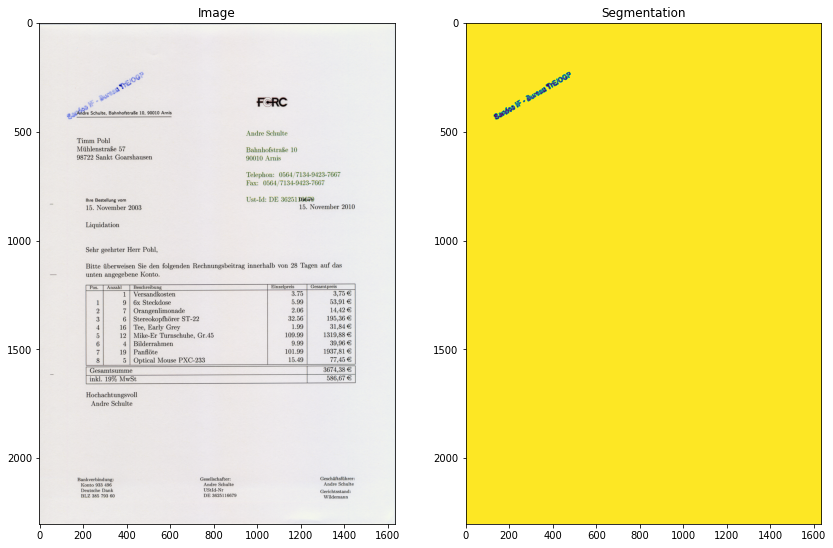

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
# mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./scans/scans/stampDS-00001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./ground-truth-pixel/ground-truth-pixel/stampDS-00001-px.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./scans/scans/stampDS-00002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./ground-truth-pixel/ground-truth-pixel/stampDS-00002-px.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./scans/scans/stampDS-00003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./ground-truth-pixel/ground-truth-pixel/stampDS-00003-px.png'>)
tf.Tensor(b'./scans/scans/stampDS-00001.png', shape=(), dtype=string)
tf.Tensor(b'./ground-truth-pixel/ground-truth-pixel/stampDS-00001-px.png', shape=(), dtype=string)


In [ ]:
from PIL import Image

image_shape = (Image.open(image_list[0]).size[1], Image.open(image_list[0]).size[0])
image_shape

(2302, 1632)

In [ ]:
IMG_SIZE = (2304, 1632)

In [ ]:
IMG_SIZE = (1152, 816)

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = 1 - tf.math.reduce_max(mask, axis=-1, keepdims=True) / 255
    return img, mask


def preprocess(image, mask):
    input_image = tf.image.resize(image, IMG_SIZE, method='nearest')
    input_mask = tf.image.resize(mask, IMG_SIZE, method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask


image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

Checking if the mask has the proper backround color

In [ ]:
mask_path = list(dataset.take(1))[0][1]
mask = tf.io.read_file(mask_path)
mask = tf.image.decode_png(mask, channels=3)
mask = 1 - tf.math.reduce_max(mask, axis=-1, keepdims=True) / 255
np.unique(mask, return_counts=True)

(array([0., 1.], dtype=float32), array([3748384,    8480]))

(2302, 1632, 1)


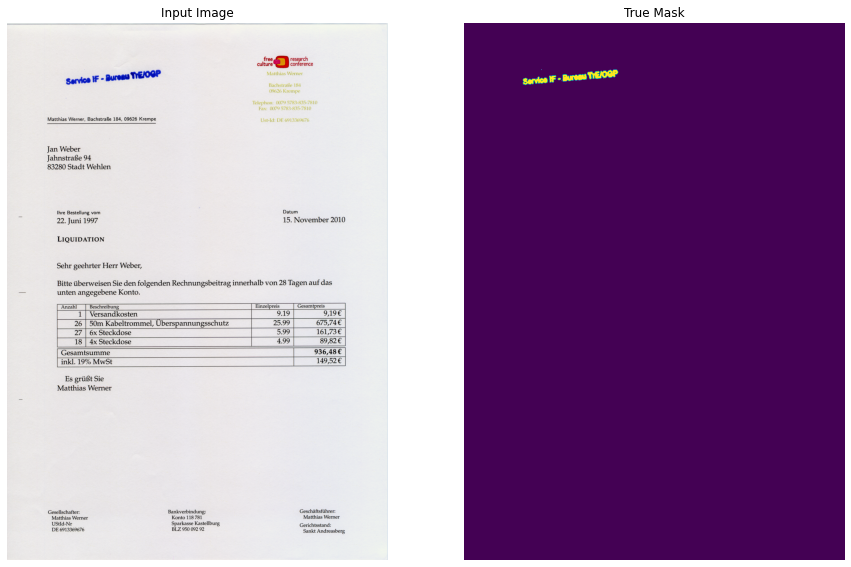

(1152, 816, 1)


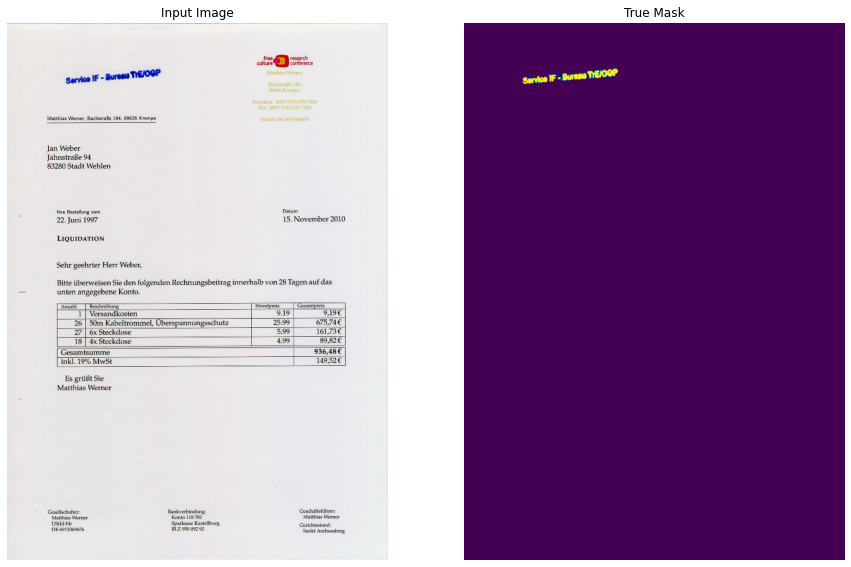

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


# %%
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

# %%
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0., max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
        ### END CODE HERE

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
        ### END CODE HERE

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    ### START CODE HERE
    up = Conv2DTranspose(
        n_filters,  # number of filters
        3,  # Kernel size
        strides=(2, 2),
        padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)

    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE

    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=2):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters) # n_filters
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2) # n_filters * 2
    cblock3 = conv_block(cblock2[0], n_filters * 4) # n_filters * 4
    cblock4 = conv_block(cblock3[0], n_filters * 8, # n_filters * 8
                         dropout_prob=0.3)  # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) # n_filters * 16
    ### END CODE HERE

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8) # n_filters * 8
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4) # n_filters * 4
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2) # n_filters * 2
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters) # n_filters * 8
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_height = IMG_SIZE[0]
img_width = IMG_SIZE[1]
num_channels = 3
n_filters = 32
input_size = (img_height, img_width, num_channels)

unet = unet_model(input_size, n_classes = 1, n_filters = n_filters)

In [ ]:
unet.summary()

In [ ]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [ ]:
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
folder_to_save = "gdrive/MyDrive/saved_models/unet_2/" + timestamp + "/"

if not os.path.isdir(folder_to_save):
  os.mkdir(folder_to_save)

In [ ]:
with open(folder_to_save + "model_stats.txt", "w") as stream:
  unet.summary(print_fn=lambda x: stream.write(x + '\n'))

In [ ]:
EPOCHS = 1
BATCH_SIZE = 2

In [ ]:
config = {"EPOCHS" : EPOCHS, 
          "BATCH_SIZE" : BATCH_SIZE,
          "n_filters" : n_filters,
          "loss_function" : "BinaryCrossentropy",
          "optimizer" : "adam",
          "metrics" : ["accuracy"]}

with open(folder_to_save + "model_config.txt", "w") as stream:
  stream.write(json.dumps(config))

In [ ]:
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().batch(BATCH_SIZE)
test_dataset = processed_image_ds.cache().take(50)
print(processed_image_ds.element_spec)

(TensorSpec(shape=(1152, 816, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1152, 816, 1), dtype=tf.float32, name=None))


In [ ]:
model_history = unet.fit(train_dataset, 
                         epochs=EPOCHS, 
                         validation_data = test_dataset,  
                         callbacks=[ModelCheckpoint(folder_to_save + 'stamp.weights.{epoch:04d}.hdf5', save_weights_only=True)])

200/200 [==============================] - 214s 1s/step - loss: 0.0298 - accuracy: 0.9982 - val_loss: 0.0129 - val_accuracy: 0.9982


In [ ]:
import csv

with open(folder_to_save + 'mycsvfile.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, model_history.history.keys())
    w.writeheader()
    w.writerow(model_history.history)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

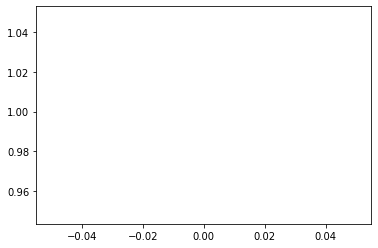

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.show()

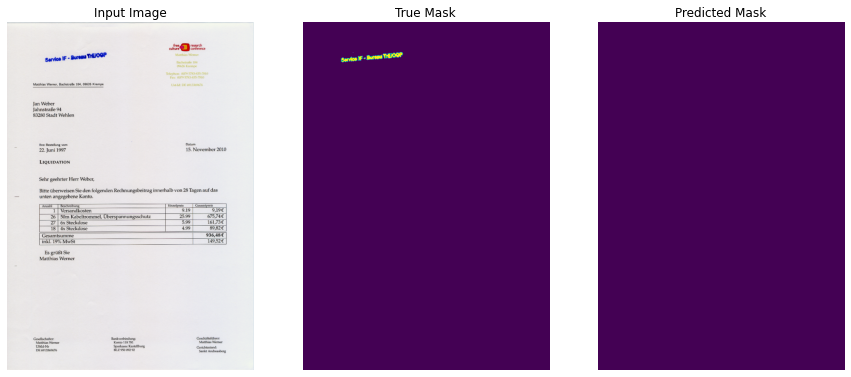

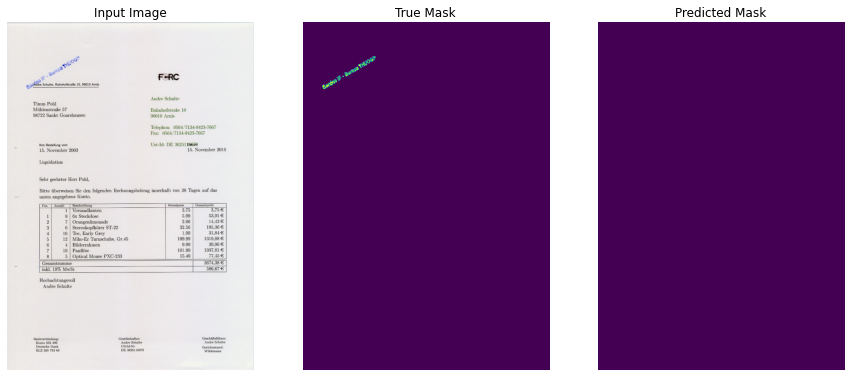

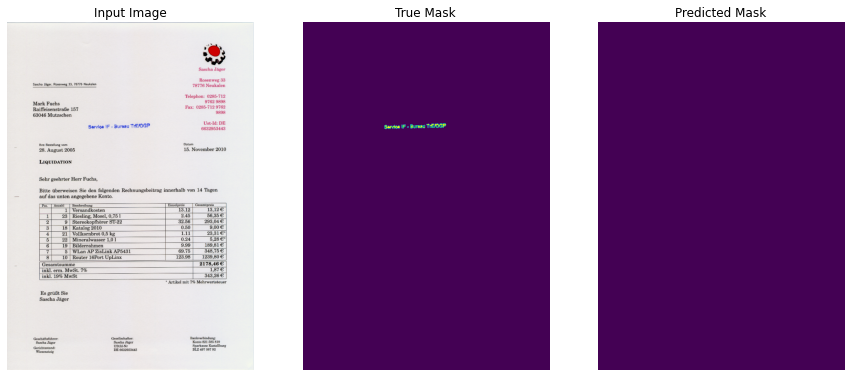

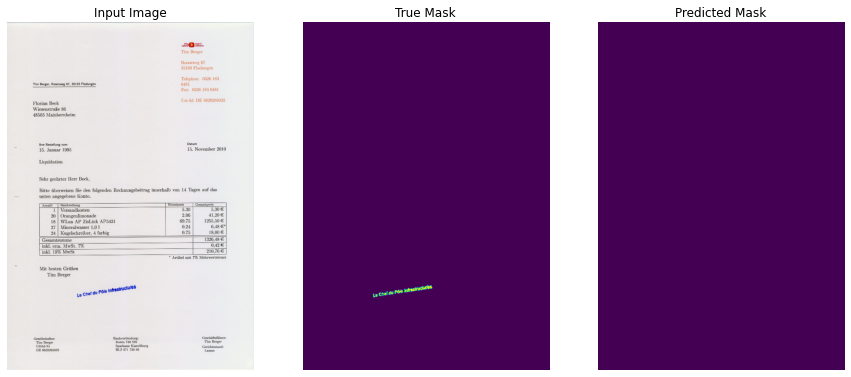

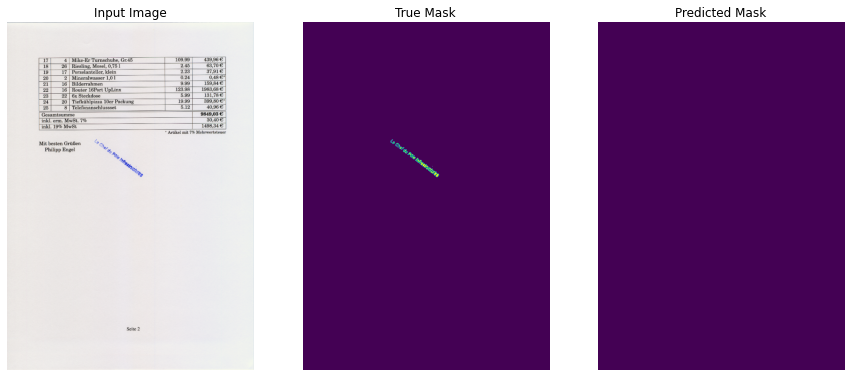

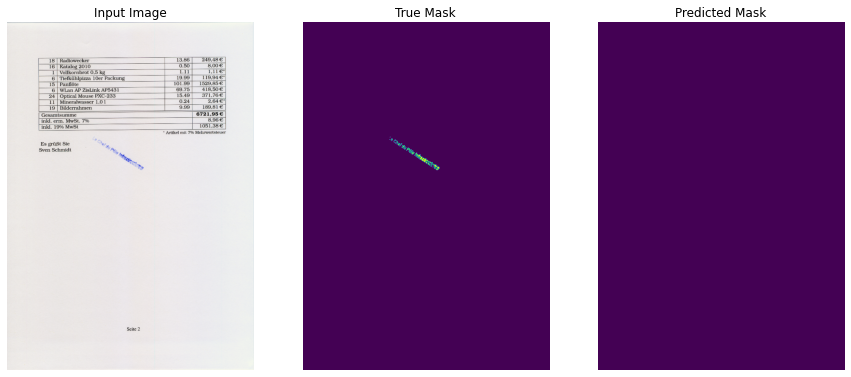

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(unet.predict(sample_image[tf.newaxis, ...]))])


# %%
show_predictions(train_dataset, 6)